In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pdb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


In [22]:
import pdb
import matplotlib
import numpy as np
np.random.seed(10)
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
from datetime import datetime
from joblib import delayed, Parallel
from collections import defaultdict, OrderedDict

from utils.generic import init_params
from main.seir.optimiser import Optimiser
from models.seir.seir_testing import SEIR_Testing
from data.processing import get_district_time_series
from data.dataloader import get_covid19india_api_data

## Load covid19 data

In [23]:
now = datetime.now()
dataframes = get_covid19india_api_data()

In [24]:
dataframes.keys()

dict_keys(['df_tested', 'df_statewise', 'df_india_time_series', 'df_districtwise', 'df_raw_data_old', 'df_raw_data', 'df_deaths_recoveries', 'df_districts', 'df_travel_history', 'df_resources'])

In [25]:
regions = [('Delhi', 'South Delhi'), ('Karnataka', 'Bengaluru Urban'), ('Maharashtra', 'Mumbai'), ('Maharashtra', 'Pune'), ('Gujarat', 'Ahmedabad'), ('Rajasthan', 'Jaipur')]
state, district = regions[3]
df_district = get_district_time_series(dataframes, state=state, district=district, use_dataframe = 'districts_daily')

/home/users/namrata/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Create train-val splits

In [26]:
# df_train = df_district
df_train = df_district.iloc[:-5, :]
df_val = df_district.iloc[-5:, :]

In [27]:
df_train

,state,district,date,hospitalised,total_infected,deceased,recovered
0,Maharashtra,Pune,2020-04-24,696,910,62,152
1,Maharashtra,Pune,2020-04-25,772,1030,73,185
2,Maharashtra,Pune,2020-04-26,770,1052,76,206
3,Maharashtra,Pune,2020-04-27,762,1052,80,210
4,Maharashtra,Pune,2020-04-28,873,1174,80,221
5,Maharashtra,Pune,2020-04-29,863,1192,85,244
6,Maharashtra,Pune,2020-04-30,912,1248,88,248
7,Maharashtra,Pune,2020-05-01,901,1248,99,248
8,Maharashtra,Pune,2020-05-02,952,1339,102,285
9,Maharashtra,Pune,2020-05-03,951,1396,106,339


## Set priors for parameters of interest

In [28]:
## assuming uniform priors, following dictionary contains the ranges
prior_ranges = OrderedDict()
prior_ranges['R0'] = (1.6, 5)
prior_ranges['T_inc'] = (4, 5)
prior_ranges['T_inf'] = (3, 4)
prior_ranges['T_recov_severe'] = (9, 20)
prior_ranges['P_severe'] = (0.3, 0.99)
prior_ranges['P_fatal'] = (1e-10, 0.3)
prior_ranges['intervention_amount'] = (1e-10, 1)
prior_ranges['sigma'] = (0, 1)

def param_init(prior_ranges):
    theta = defaultdict()
    for key in prior_ranges:
        theta[key] = np.random.uniform(prior_ranges[key][0], prior_ranges[key][1])
        
    return theta

## Proposal function to sample theta_new given theta_old

In [29]:
proposal_sigmas = OrderedDict()
proposal_sigmas['R0'] = 20
proposal_sigmas['T_inc'] = np.exp(10)
proposal_sigmas['T_inf'] = np.exp(10)
proposal_sigmas['T_recov_severe'] = np.exp(100)
proposal_sigmas['P_severe'] = 10
proposal_sigmas['P_fatal'] = 10
proposal_sigmas['intervention_amount'] = 10
proposal_sigmas['sigma'] = 10

def proposal(theta_old, proposal_sigmas):
    theta_new = [np.nan]
    
    while np.isnan(theta_new).any():
        theta_new = np.random.normal(loc=np.exp([*theta_old.values()]), scale=[*proposal_sigmas.values()])
        theta_new = np.log(theta_new)
    
    return dict(zip(theta_old.keys(), theta_new))


In [30]:
theta = param_init(prior_ranges)
new_theta = proposal(theta, proposal_sigmas)
for key in theta:
    print(key, theta[key], new_theta[key])

R0 4.222490187106937 4.481179053085134
T_inc 4.0207519493594015 9.815049662158101
T_inf 3.6336482349262753 8.90131666378026
T_recov_severe 17.23684270792473 99.23662484036284
P_severe 0.6439698384887873 1.6785501018791147
P_fatal 0.06743899373677463 1.640767378336256
intervention_amount 0.1980628648398177 1.5333280708636654
sigma 0.7605307121989587 3.079364431740721


<ipython-input-29-d6855e49d64c>:16: RuntimeWarning: invalid value encountered in log
  theta_new = np.log(theta_new)


## Log Likelihood and Prior

In [31]:
def log_likelihood(theta, df_train, fit_days=-10):
    if (np.array([*theta.values()]) < 0).any():
        return -np.inf
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(df_train)
    df_prediction = optimiser.solve(theta, default_params, df_train)
    pred = np.array(df_prediction['total_infected'][fit_days:])
    true = np.array(df_train['total_infected'][fit_days:])
    sigma = theta['sigma']
    N = len(true)
    ll = - (N * np.log(np.sqrt(2*np.pi) * sigma)) - (np.sum(((true - pred) ** 2) / (2 * sigma ** 2)))
    return ll

def log_prior(theta):
    if (np.array([*theta.values()]) < 0).any():
        prior = 0
    else:
        prior = 1
    
    return np.log(prior)

def in_valid_range(key, value):
    return (value <= prior_ranges[key][1]) and (value >= prior_ranges[key][0])

## Acceptance function

In [32]:
def accept(theta_old, theta_new, df_train):    
    x_new = log_likelihood(theta_new, df_train) + log_prior(theta_new)
    x_old = log_likelihood(theta_old, df_train) + log_prior(theta_old)
    
    if (x_new) > (x_old):
        return True
    else:
        x = np.random.uniform(0, 1)
        return (x < np.exp(x_new - x_old))
    
def anneal_accept(iter):
    prob = 1 - np.exp(-(1/(iter + 1e-10)))
    x = np.random.uniform(0, 1)
    return (x < prob)

## Metropolis loop

In [33]:
def metropolis(prior_ranges, proposal_sigmas, df_train, iter=1000):
    theta = param_init(prior_ranges)
    accepted = [theta]
    rejected = list()
    
    for i in tqdm(range(iter)):
        theta_new = proposal(theta, proposal_sigmas)
        if accept(theta, theta_new, df_train):
            theta = theta_new
        else:
            rejected.append(theta_new)
        accepted.append(theta)
    
    return accepted, rejected

## Prediction Interval calculator

In [34]:
def get_PI(pred_dfs, date, key, multiplier=1.96):
    pred_samples = list()
    for df in pred_dfs:
        pred_samples.append(df.loc[date, key])
        
    mu = np.array(pred_samples).mean()
    sigma = np.array(pred_samples).std()
    low = mu - multiplier*sigma
    high = mu + multiplier*sigma
    return mu, low, high

## Run multiple chains in parallel

In [35]:
n_chains = 5
mcmc = Parallel(n_jobs=mp.cpu_count())(delayed(metropolis)(prior_ranges, proposal_sigmas, df_train, iter=20000) for run in range(n_chains))


## Checking validity with Gelman-Rubin statistics

Check Section 4.2 [here](http://www.columbia.edu/~mh2078/MachineLearningORFE/MCMC_Bayes.pdf)

In [36]:
def accumulate(dict_list):
    accumulator = defaultdict(int)
    for elt in dict_list:
        for key in elt:
            accumulator[key]+=elt[key]
    return accumulator

def divide(dictvar, num):
    return {key:dictvar[key]/num for key in dictvar}

            
def avg_sum_chain(chain):
    chain_sums_avg = accumulate(chain)
    return divide(chain_sums_avg, len(chain))

def avg_sum_multiple_chains(chain_sums_avg):
    multiple_chain_sums_avg = accumulate(chain_sums_avg)
    return divide(multiple_chain_sums_avg, len(chain_sums_avg))

def compute_B(multiple_chain_sums_avg, chain_sums_avg, n, m):
    B = defaultdict(int)
    for elt in chain_sums_avg:
        for key in elt:
            B[key] += np.square(elt[key] - multiple_chain_sums_avg[key])
    return divide(B, (m-1)/n)

def compute_W(split_chains, chain_sums_avg, n, m):
    s = []
    for j in range(m):
        s_j_sq = defaultdict(int)
        chain = split_chains[j]
        chain_sum_avg_j = chain_sums_avg[j]
        for i in range(n):
            chain_elt = chain[i]
            for key in chain_elt:
                s_j_sq[key] += np.square(chain_elt[key] - chain_sum_avg_j [key])
        s_j_sq = divide(s_j_sq, n - 1)
        s.append(s_j_sq)
    return (divide (accumulate(s),m))

def divide_dict(d1, d2):
    accumulator = defaultdict(int)
    for key in d1:
        accumulator[key] = d1[key]/d2[key]
    return accumulator

In [37]:
burn_in = int(len(mcmc[0][0]) / 2)
chains = [mcmc_chain[0] for mcmc_chain in mcmc]
burn_in = int(len(chains[0]) / 2)
sampled_chains = [chain[:burn_in] for chain in chains]
split_chains = [sampled_chain[int(burn_in/2):] for sampled_chain in sampled_chains] \
            + [sampled_chain[:int(burn_in/2)] for sampled_chain in sampled_chains]

chain_sums_avg = []
for chain in split_chains:
    chain_sums_avg.append(avg_sum_chain(chain))
multiple_chain_sums_avg = avg_sum_multiple_chains(chain_sums_avg) 


m = len(split_chains)
n = len(split_chains[0])
W =  compute_W(split_chains, chain_sums_avg, n, m)
B =  compute_B(multiple_chain_sums_avg, chain_sums_avg, n, m)
var_hat = accumulate([divide(W, n/(n-1)), divide(B, n) ])
R_hat_sq = divide_dict(var_hat, W)
R_hat = {key:np.sqrt(value) for key, value in R_hat_sq.items()}
neff = divide_dict(var_hat, B)
neff = {key: m*n*value for key, value in neff.items()}

import pprint
pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(neff)
pp.pprint(R_hat)

{   'P_fatal': 1.8479543603562019,
    'P_severe': 4.490845881866318,
    'R0': 4.797952514030584,
    'T_inc': 3.671640498053475,
    'T_inf': 1.314497807270147,
    'T_recov_severe': 1.1432327284582784,
    'intervention_amount': 6.260393396430125,
    'sigma': 3.0296339802536694}


## Visualize the samples and intervals

In [38]:
def visualize(compartments: list, end_date: str = None): 
    data_split = pd.concat([df_train, df_val])
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(data_split)
    
    combined_acc = list()
    for k, run in enumerate(mcmc):
        burn_in = int(len(run) / 2)
        combined_acc += run[0][burn_in:]

    n_samples = 1000
    sample_indices = np.random.uniform(0, len(combined_acc), n_samples)

    pred_dfs = list()
    for i in tqdm(sample_indices):
        pred_dfs.append(optimiser.solve(combined_acc[int(i)], default_params, data_split, end_date=end_date))

    for df in pred_dfs:
        df.set_index('date', inplace=True)

    result = pred_dfs[0].copy()
    for col in result.columns:
        result["{}_low".format(col)] = ''
        result["{}_high".format(col)] = ''

    for date in tqdm(pred_dfs[0].index):
        for key in pred_dfs[0]:
            result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(pred_dfs, date, key)

    data_split.set_index("date", inplace=True)

    plt.figure(figsize=(15, 10))
    train_start_date = df_train.iloc[-10, :]['date']
    train_end_date = df_train.iloc[-1, :]['date']
    
    actual = data_split[data_split.index >= train_start_date]
    pred = result[result.index >= train_start_date]
    
    color = plt.cm.rainbow(np.linspace(0,1,len(compartments)))

    for i, bucket in enumerate(compartments):
        plt.plot(actual.index.array, actual[bucket].tolist(), c=color[i], marker='o', label='Actual {}'.format(bucket))
        plt.plot(pred.index.array, pred[bucket].tolist(), c=color[i], label='Estimated {}'.format(bucket))
        plt.plot(pred.index.array, pred['{}_low'.format(bucket)].tolist(), c=color[i], linestyle='dashdot')
        plt.plot(pred.index.array, pred['{}_high'.format(bucket)].tolist(), c=color[i], linestyle='dashdot')
    plt.axvline(x=train_end_date, c='k', linestyle='dashed', label='train ends')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title("95% confidence intervals for {}, {}".format(district, state))
    plt.tight_layout()
    
    plt.savefig('./mcmc_confidence_intervals_{}_{}.png'.format(district, state))
    plt.show()

100%|██████████| 62/62 [00:08<00:00,  6.92it/s]


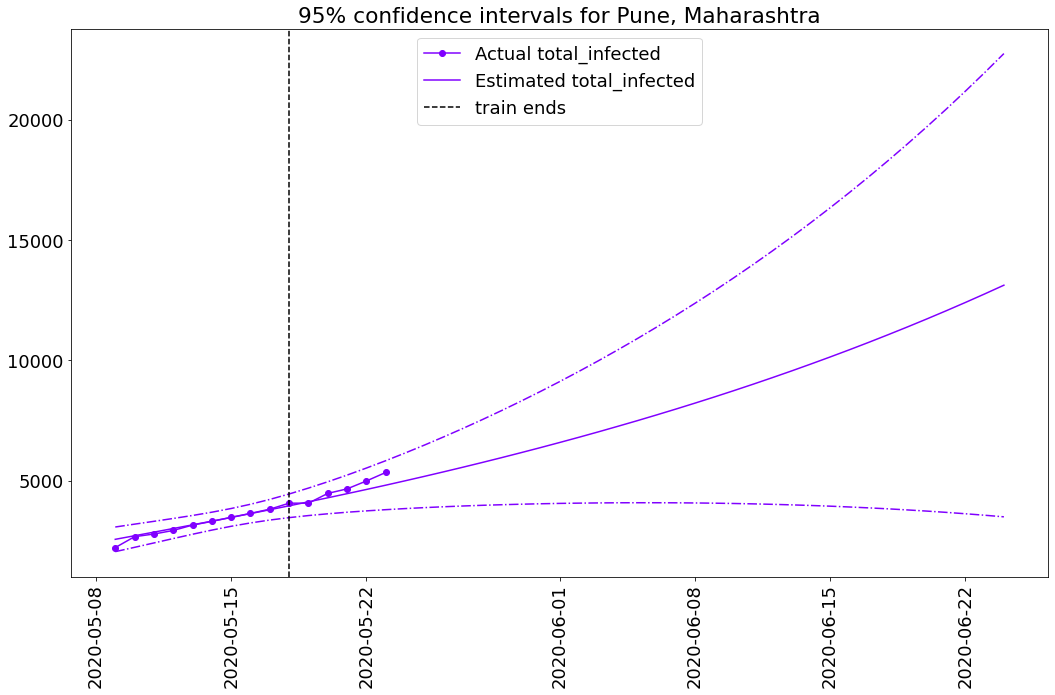

In [39]:
compartments = ["total_infected"]#, "hospitalised", "recovered", "deceased"]
visualize(compartments, end_date="2020-06-24")

## Visualize all runs separately

In [20]:
def analyse_runs(df_district, mcmc, district, state):
    plt.figure(figsize=(30, 50))

    for k, run in enumerate(mcmc):
        data_split = df_district.copy()
        optimiser = Optimiser()
        default_params = optimiser.init_default_params(data_split)

        acc, rej = run[0], run[1]
        df_samples = pd.DataFrame(acc)

        plt.subplot(len(mcmc), 3, 3*k + 1)
        for param in df_samples.columns:
            plt.plot(list(range(len(df_samples[param]))), df_samples[param], label=param)
        plt.xlabel("iterations")
        plt.legend()
        plt.title("Accepted samples from run {}".format(k+1))

        rej_samples = pd.DataFrame(rej)

        plt.subplot(len(mcmc), 3, 3*k + 2)
        for param in rej_samples.columns:
            plt.scatter(list(range(len(rej_samples[param]))), rej_samples[param], label=param, s=2)
        plt.xlabel("iterations")
        plt.legend()
        plt.title("Rejected samples from run {}".format(k+1))

        burn_in = int(len(acc) / 2)
        n_samples = 1000
        posterior_samples = acc[burn_in:]
        sample_indices = np.random.uniform(0, len(posterior_samples), n_samples)

        pred_dfs = list()
        for i in tqdm(sample_indices):
            pred_dfs.append(optimiser.solve(posterior_samples[int(i)], default_params, data_split))

        for df in pred_dfs:
            df.set_index('date', inplace=True)

        result = pred_dfs[0].copy()
        for col in result.columns:
            result["{}_low".format(col)] = ''
            result["{}_high".format(col)] = ''

        for date in tqdm(pred_dfs[0].index):
            for key in pred_dfs[0]:
                result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(pred_dfs, date, key)

        data_split.set_index("date", inplace=True)

        plt.subplot(len(mcmc), 3, 3*k + 3)
        color = plt.cm.rainbow(np.linspace(0,1,len(compartments)))
        for i, bucket in enumerate(compartments):
            plt.plot(data_split.index.array, data_split[bucket].tolist(), c=color[i], marker='o', label='Actual {}'.format(bucket))
            plt.plot(result.index.array, result[bucket].tolist(), c=color[i], label='Estimated {}'.format(bucket))
            plt.plot(result.index.array, result['{}_low'.format(bucket)].tolist(), c=color[i], linestyle='dashdot')
            plt.plot(result.index.array, result['{}_high'.format(bucket)].tolist(), c=color[i], linestyle='dashdot')
        plt.axvline(x=df_train['date'][len(df_train)-1], c='b', linestyle='dashed', label='train-test boundary')
        plt.xticks(rotation=90)
        plt.ylabel("Total infected")
        plt.legend()
        plt.title("95% confidence intervals for {}, {}".format(district, state))
        plt.tight_layout()

    plt.savefig("./mcmc_runs_{}_{}.png".format(district, state))
    plt.show()

In [ ]:
# analyse_runs(df_district, mcmc, district, state)